In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

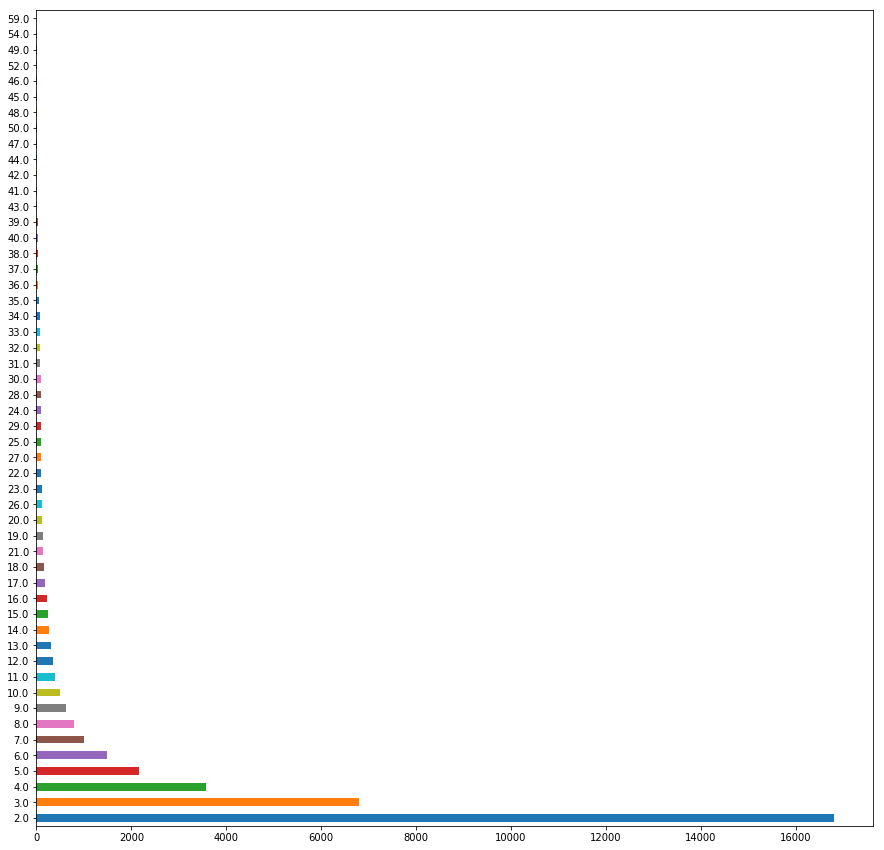

In [3]:
df = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
df['country_count'] = 1
df.drop(['is_original_title', 'ordering'], axis=1, inplace=True)
df = df.groupby(['region','title_id']).sum()
df_unstacked = df.unstack()
df_unstacked

country_counter = df_unstacked.sum(axis=0).sort_values(ascending=False)
country_counter = country_counter.unstack()
country_counter


domestic_films = []

for movie in country_counter.keys():
    if country_counter[movie]['country_count'] <= 1:
            domestic_films.append(movie)
    
    
country_counter_int = country_counter.drop(domestic_films, axis=1)
country_counter_int.iloc[0].value_counts().plot.barh(figsize=(15,15));

In [4]:
country_counter_int.keys()

Index(['tt2488496', 'tt2310332', 'tt1201607', 'tt2278871', 'tt1790809', 'tt2948356', 'tt0398286', 'tt1345836', 'tt2452042', 'tt2820852',
       ...
       'tt1924340', 'tt1531667', 'tt6449738', 'tt2261409', 'tt2380282', 'tt6143782', 'tt3763118', 'tt4978138', 'tt4932580', 'tt3243554'], dtype='object', name='title_id', length=37753)

In [26]:
int_movie_counter = {}

int_movie_counter['tconst'] = country_counter_int.keys()
count_list = []

for movie in country_counter_int.keys():
    count_list.append(country_counter_int[movie]['country_count'])    
    
int_movie_counter['country_count'] = count_list
      
country_counts = pd.DataFrame.from_dict(int_movie_counter)
country_counts

,tconst,country_count
0,tt2488496,59.0
1,tt2310332,54.0
2,tt1201607,54.0
3,tt2278871,52.0
4,tt1790809,52.0
5,tt2948356,52.0
6,tt0398286,50.0
7,tt1345836,50.0
8,tt2452042,50.0
9,tt2820852,50.0


In [24]:
movie_titles = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
movie_titles

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


In [ ]:
country_counts.join(movie_titles, on='primar')